# S-Bert Pipeline

In [1]:
from typing import List, Union, Tuple

import torch
from sentence_transformers import SentenceTransformer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from arqmath_code.Entities.Post import Question, Answer
from arqmath_code.topic_file_reader import Topic

## Simple example

In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')
sentences = ['This framework generates embeddings for each input sentence',
             'This framework creates embeddings for input sentences',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

embeddings = model.encode(sentences)

for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: This framework generates embeddings for each input sentence
Embedding: [-1.37173980e-02 -4.28515561e-02 -1.56286508e-02  1.40537312e-02
  3.95538285e-02  1.21796280e-01  2.94333734e-02 -3.17523777e-02
  3.54959518e-02 -7.93140382e-02  1.75878499e-02 -4.04369496e-02
  4.97259647e-02  2.54912600e-02 -7.18700662e-02  8.14968124e-02
  1.47069187e-03  4.79627140e-02 -4.50335406e-02 -9.92174447e-02
 -2.81769410e-02  6.45045564e-02  4.44671251e-02 -4.76217046e-02
 -3.52952220e-02  4.38671559e-02 -5.28565943e-02  4.32974688e-04
  1.01921484e-01  1.64072495e-02  3.26997079e-02 -3.45986448e-02
  1.21339923e-02  7.94870779e-02  4.58342349e-03  1.57778580e-02
 -9.68202204e-03  2.87626311e-02 -5.05806915e-02 -1.55794229e-02
 -2.87907310e-02 -9.62286349e-03  3.15556489e-02  2.27349084e-02
  8.71449336e-02 -3.85027863e-02 -8.84718671e-02 -8.75497423e-03
 -2.12343559e-02  2.08923556e-02 -9.02078226e-02 -5.25732487e-02
 -1.05638858e-02  2.88310666e-02 -1.61455218e-02  6.17834646e-03
 -1.23234

## Plotting embeddings

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
transformed = pd.DataFrame(pca.fit_transform(embeddings))
print(transformed)

          0         1
0 -0.384995 -0.242677
1 -0.383845 -0.312131
2 -0.156728  0.671490
3  0.925569 -0.116683


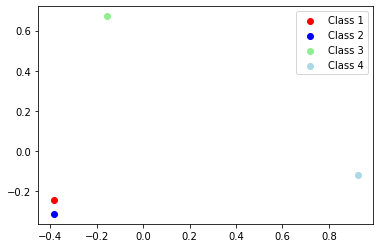

In [20]:
plt.scatter(transformed.iloc[0][0], transformed.iloc[0][1], label='Class 1', c='red')
plt.scatter(transformed.iloc[1][0], transformed.iloc[1][1], label='Class 2', c='blue')
plt.scatter(transformed.iloc[2][0], transformed.iloc[2][1], label='Class 3', c='lightgreen')
plt.scatter(transformed.iloc[3][0], transformed.iloc[3][1], label='Class 4', c='lightblue')

plt.legend()
plt.show()

## Simple and Basic S-Bert IR Model

In [2]:
from src import init_data
topic_reader, data_reader = init_data(task=1)

reading users
reading comments
reading votes
reading post links
reading posts


In [3]:
from numpy import ndarray
import torch
import numpy as np
from torch import Tensor
from src.base.model import Model
from sentence_transformers.util import cos_sim
from typing import List, Union, Tuple, Dict
from arqmath_code.topic_file_reader import Topic
from arqmath_code.Entities.Post import Question, Answer
import os
import json

class QuestionSBERT(Model):

    def __init__(self):
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.path = '../arqmath_dataset/model_embeddings/'
        self.document_path = os.path.join(self.path, "document_embeddings.npy")
        self.index_path = os.path.join(self.path ,"index.json")

    def _save_embeddings(self, embedding: Union[list[Tensor], ndarray, ndarray, Tensor], document_index: Dict[int, Union[Question, Answer]]):
        np.save(self.document_path, embedding)
        index_to_save = {index: document.post_id for index, document in document_index.items()}
        with open(self.index_path, 'w+') as file:
            file.write(json.dumps(index_to_save))

    def _load_embeddings(self, documents: List[Union[Question, Answer]]) -> (ndarray, Dict[int, Union[Question, Answer]]):
        embeddings = np.load(self.document_path)
        id_to_object_index = {doc.post_id: doc for doc in documents}
        with open(self.index_path, 'r') as f:
            saved_index: Dict[int, int] = json.load(f)
        document_index = {int(index): id_to_object_index[doc_id] for index, doc_id in saved_index.items()}
        return embeddings, document_index

    def forward(self, queries: List[Topic], documents: List[Union[Question, Answer]]) -> List[
        Tuple[Topic, Union[Question, Answer], float]]:
        if not os.path.isfile(self.document_path):
            document_title_embeddings = self.model.encode([document.title for document in documents])
            document_index = {documents.index(document): document for document in documents}
            self._save_embeddings(embedding=document_title_embeddings, document_index=document_index)

        else:
            print("read from cached embeddings at ", self.document_path)
            document_title_embeddings, document_index = self._load_embeddings(documents=documents)

        query_title_embeddings = self.model.encode([query.title for query in queries])
        scores: torch.Tensor = cos_sim(query_title_embeddings, document_title_embeddings) # r[i] -> row of query sims
        res: np.ndarray = np.array(
            [list(zip(
                [queries[i] for _ in range(scores[i].size()[0])],
                [document_index[idx] for idx in range(scores[i].size()[0])],
                scores[i].numpy()
            )) for i in range(scores.size()[0])]
        )
        res = res.reshape(res.shape[0] * res.shape[1], res.shape[2])
        return list(map(lambda arr: tuple(arr), res))


        #return query_title_embeddings, document_title_embeddings #, scores

In [125]:
from datetime import datetime
simple_sbert = QuestionSBERT()
questions = data_reader.get_questions()
print(len(questions))
print(datetime.now())
res = simple_sbert(queries=[topic_reader.get_topic('A.301'), topic_reader.get_topic('A.302')], documents=questions[:10])
print(datetime.now())
res

1020585
2022-11-15 15:37:46.998458
2022-11-15 15:37:47.082071


[(<arqmath_code.topic_file_reader.Topic at 0x29da31160>,
  0.11493918),
 (<arqmath_code.topic_file_reader.Topic at 0x29da31160>,
  0.1816909),
 (<arqmath_code.topic_file_reader.Topic at 0x29da31160>,
  0.124751456),
 (<arqmath_code.topic_file_reader.Topic at 0x29da31160>,
  -0.017077109),
 (<arqmath_code.topic_file_reader.Topic at 0x29da31160>,
  -0.037476216),
 (<arqmath_code.topic_file_reader.Topic at 0x29da31160>,
  0.4129994),
 (<arqmath_code.topic_file_reader.Topic at 0x29da31160>,
  -0.038757503),
 (<arqmath_code.topic_file_reader.Topic at 0x29da31160>,
  0.042250134),
 (<arqmath_code.topic_file_reader.Topic at 0x29da31160>,
  0.19352183),
 (<arqmath_code.topic_file_reader.Topic at 0x29da31160>,
  -0.011618398),
 (<arqmath_code.topic_file_reader.Topic at 0x29e70e250>,
  0.07959521),
 (<arqmath_code.topic_file_reader.Topic at 0x29e70e250>,
  0.1326235),
 (<arqmath_code.topic_file_reader.Topic at 0x29e70e250>,
  0.20463361),
 (<arqmath_code.topic_file_reader.Topic at 0x29e70e250>,


In [7]:
from src.base.post_processor import PostProcessor


class AnswerScoreRetriever(PostProcessor):

    def forward(self, queries: List[Topic], ranking: List[Tuple[Topic, Union[Question, Answer], float]]) -> List[
        Tuple[Topic, Union[Question, Answer], float]]:
        ranking = filter(lambda t: t[1].answers is not None, ranking)
        return [
            (topic, question.answers[0], score)
            for topic, question, score in ranking
        ]


In [5]:
from src.post_processors.TopKFilter import TopKFilter
from arqmath_code.post_reader_record import DataReaderRecord
from src.base.pipeline import Pipeline

class SBertPipeline(Pipeline):

    def __init__(self, data_reader: DataReaderRecord):
        super().__init__(data_reader)
        self.sbert = QuestionSBERT()
        self.answer_score_retriever = AnswerScoreRetriever()
        self.top_k_filter = TopKFilter()

    def run(self, queries: List[Topic]) -> List[Tuple[Topic, Answer, float]]:
        questions: List[Question] = self.data_reader.get_questions()[:1000]
        ranking: List[
        Tuple[Topic, Union[Question, Answer], float]] = self.sbert(queries=queries, documents=questions)
        ranking = self.answer_score_retriever(queries=queries, ranking=ranking)
        ranking = self.top_k_filter(queries=queries, ranking=ranking)
        return ranking




In [8]:
from src.runner import Runner
from datetime import datetime

print(datetime.now())
runner = Runner(SBertPipeline, n=1, data_reader=data_reader, topic_reader=topic_reader)
ranking = runner.run("../results/model_results/SBert-test.tsv")
print(datetime.now())
ranking

2022-11-15 17:18:03.042102
read from cached embeddings at  ../arqmath_dataset/model_embeddings/document_embeddings.npy
2022-11-15 17:18:04.740487


,Topic_Id,Post_Id,Score,Run_Number,Rank
0,A.301,981,0.527293,0,0
1,A.301,3666,0.524437,0,1
2,A.301,1311280,0.515361,0,2
3,A.301,4122,0.490944,0,3
4,A.301,340,0.476349,0,4
...,...,...,...,...,...
99095,A.400,1029,-0.124593,0,986
99096,A.400,456,-0.128740,0,987
99097,A.400,1863,-0.129682,0,988
99098,A.400,413,-0.134927,0,989


In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
q_transformed = pd.DataFrame(pca.fit_transform(q_emb))
d_transformed = pd.DataFrame(pca.fit_transform(d_emb))
print(d_transformed)

              0         1
0     -0.064889 -0.043494
1     -0.045415  0.041631
2     -0.062295  0.007746
3     -0.195928  0.033659
4     -0.089345  0.146417
...         ...       ...
99995 -0.036558 -0.016462
99996 -0.140381  0.059406
99997 -0.237232 -0.008983
99998 -0.272687  0.178042
99999  0.176759  0.208574

[100000 rows x 2 columns]


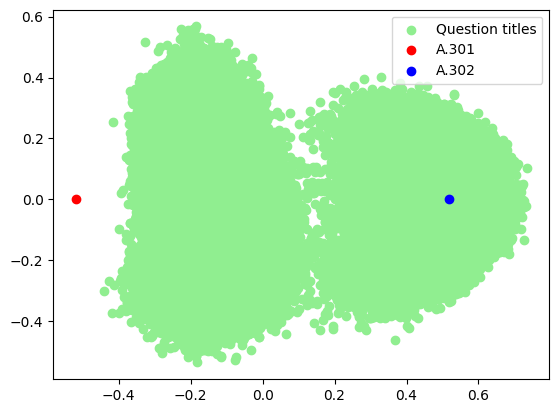

In [10]:
plt.scatter(d_transformed[0], d_transformed[1], label='Question titles', c='lightgreen')
plt.scatter(q_transformed.iloc[0][0], q_transformed.iloc[0][1], label='A.301', c='red')
plt.scatter(q_transformed.iloc[1][0], q_transformed.iloc[1][1], label='A.302', c='blue')
# plt.scatter(transformed.iloc[3][0], transformed.iloc[3][1], label='Class 4', c='lightblue')

plt.legend()
plt.show()

## check embedding loading

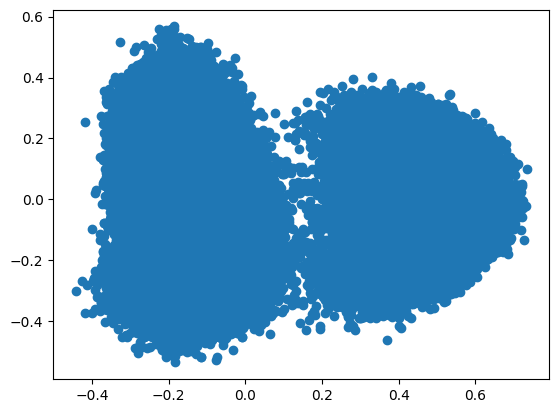

In [14]:
test = np.load('../arqmath_dataset/model_embeddings/test.npy')
test_transformed = pd.DataFrame(pca.fit_transform(test))
plt.scatter(test_transformed[0], test_transformed[1])
plt.show()